In [1]:
# %% Imports
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import copy
import pandas as pd
import time

# Set GPU device
print(torch.cuda.is_available())
device = torch.device("cuda:0")

True


In [2]:
# Download dataset from Google Drive
! gdown --id 1-6ekgyym3PYND6Z9oRlVo8sE5XV8B_km

# Links

# Zero Pad 128: 1-9hnSKSnqQmELI5_PAPy9BhLDc-bKEbE

# White Pad 128: 1ZdK5f5rbR4E7rzzAIXm84L8Mjp9HCfS0

# Zero Pad 224: 1-9sy-KxqUqBsW-GcsvfThzQL-0QiMfBS

# White Pad 224: 1-6ekgyym3PYND6Z9oRlVo8sE5XV8B_km

# Zero Pad 512: 1-DYICH8IyqrQh--WprRTrpYDzS-QgUc0

# White Pad 512: 1-AmotnWWdvKNxYlkGCS4BkrLY1BnrnaU

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1-6ekgyym3PYND6Z9oRlVo8sE5XV8B_km
From (redirected): https://drive.google.com/uc?id=1-6ekgyym3PYND6Z9oRlVo8sE5XV8B_km&confirm=t&uuid=8908e93e-72f8-41e4-a68c-294be1c9dc3b
To: /content/White_Pad_224.zip
100% 608M/608M [00:07<00:00, 80.9MB/s]


In [3]:
! mkdir data
!unzip White_Pad_224.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/white_pad_224/1_Sclerotic/S-1909-007195_PAS_2of2_647582c3435c92704a444147.png  
  inflating: content/white_pad_224/1_Sclerotic/S-2006-001849_PAS_1of2_64542f6e435c92704a3575ff.png  
  inflating: content/white_pad_224/1_Sclerotic/S-1910-000090_PAS_1of2_64551d4e435c92704a3d0f4c.png  
  inflating: content/white_pad_224/1_Sclerotic/S-2102-006457_PAS_2of2_645527ff435c92704a3ef449.png  
  inflating: content/white_pad_224/1_Sclerotic/S-2010-013043_PAS_1of2_64552795435c92704a3e03c2.png  
  inflating: content/white_pad_224/1_Sclerotic/S-2006-003978_PAS_2of2_645432e3435c92704a38b27a.png  
  inflating: content/white_pad_224/1_Sclerotic/S-1908-009734_PAS_2of2_64551cdf435c92704a3c452b.png  
  inflating: content/white_pad_224/1_Sclerotic/S-2102-006457_PAS_2of2_645527ff435c92704a3ef441.png  
  inflating: content/white_pad_224/1_Sclerotic/S-2103-004716_PAS_2of2_64552857435c92704a3faeb0.png  
  inflating: content/white_pad_224/1_Scl

In [5]:
! mv content/* data

In [6]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/data/white_pad_224', output="output", seed=1345, ratio=(0.8, 0.1,0.1))

Copying files: 5758 files [00:02, 2695.99 files/s]


In [7]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
TRAIN_ROOT = '/content/output/train'
VAL_ROOT = '/content/output/val'
TEST_ROOT = '/content/output/test'
train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_ROOT)
val_dataset = torchvision.datasets.ImageFolder(root=VAL_ROOT)
test_dataset = torchvision.datasets.ImageFolder(root=TEST_ROOT)

In [3]:
# %% Building the model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)

        for param in self.resnet18.parameters():
         param.requires_grad = False

        # Replace output layer according to our problem
        in_feats = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(in_feats, 2)


    def forward(self, x):
        x = self.resnet18(x)
        return x

model = CNNModel()
model.to(device)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CNNModel(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

In [4]:
train_dataset = torchvision.datasets.ImageFolder(
        root=TRAIN_ROOT,
        transform=transforms.Compose([
                      transforms.Resize((224, 224)),
                      transforms.ToTensor()
        ])
)

test_dataset = torchvision.datasets.ImageFolder(
        root=TEST_ROOT,
        transform=transforms.Compose([
                      transforms.Resize((224, 224)),
                      transforms.ToTensor()
        ])
)

val_dataset = torchvision.datasets.ImageFolder(
        root=VAL_ROOT,
        transform=transforms.Compose([
                      transforms.Resize((224, 224)),
                      transforms.ToTensor()
        ])
)

In [5]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [6]:
cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100

trainLoss = torch.zeros(epochs)
devLoss   = torch.zeros(epochs)
trainAcc  = torch.zeros(epochs)
devAcc    = torch.zeros(epochs)

# Start timing
torch.cuda.synchronize()
start_time = time.time()



for epoch in range(epochs):
    print(f'Epoch {epoch}')
    model.train()
    batchLoss = []
    batchAcc  = []

    for i, batch in enumerate(train_loader, 0):
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = cross_entropy_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        batchLoss.append(loss.item())
        batchAcc.append( torch.mean((torch.argmax(outputs,axis=1) == labels).float()).item() )

    trainLoss[epoch] = np.mean(batchLoss)
    trainAcc[epoch]  = 100*np.mean(batchAcc)

    model.eval()
    X,y = next(iter(val_loader))

    X = X.to(device)
    y = y.to(device)

    with torch.no_grad():
      yHat = model(X)
      loss = cross_entropy_loss(yHat,y)

    devLoss[epoch] = loss.item()
    devAcc[epoch]  = 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item()




# End timing
torch.cuda.synchronize()
end_time = time.time()

# Calculate elapsed time
gpu_time = end_time - start_time
print(f"GPU time for training: {gpu_time:.2f} seconds")

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
GPU time for training: 1908.09 seconds


In [7]:
test_data_loader = iter(test_loader)
count = 0
testAcc = 0
testLoss = 0

for i in range(1000000):
  try:
    inputs, labels = next(test_data_loader)
    inputs = inputs.to(device)
    labels = labels.numpy()

    model.eval()
    with torch.no_grad():
      outputs = model(inputs).max(1).indices.detach().cpu().numpy()
      comparison = pd.DataFrame()
      testAcc += (labels==outputs).sum()/len(labels)
      testLoss += loss.item()
      count += 1
  except StopIteration:
    break

testAcc = (testAcc/count) * 100
testLoss = (testLoss/count)

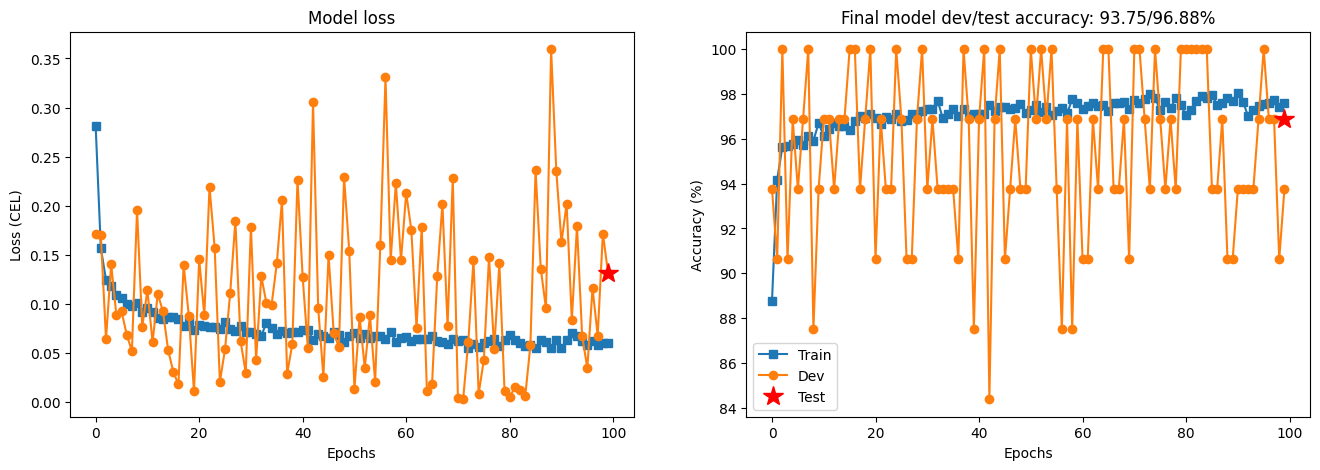

In [8]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Dev')
ax[0].plot(len(devLoss)-1,testLoss,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devAcc,'o-',label='Dev')
ax[1].plot(len(devAcc)-1,testAcc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {devAcc[-1]:.2f}/{testAcc:.2f}%')
ax[1].legend()

plt.show()

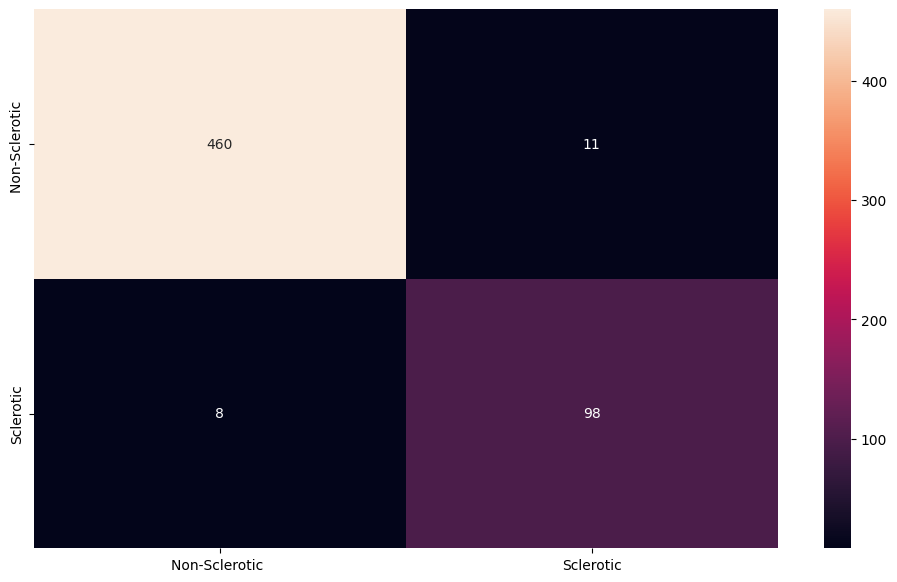

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        # push data to GPU
        inputs = inputs.to(device)

        model.eval()
        # forward pass and loss
        with torch.no_grad():
            output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Non-Sclerotic ', 'Sclerotic')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True, fmt='d')
plt.savefig('ResNet18_5epochs_confusion_matrix.png')
plt.show()

In [10]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=['Non-Sclerotic ', 'Sclerotic']))

                precision    recall  f1-score   support

Non-Sclerotic        0.98      0.98      0.98       471
     Sclerotic       0.90      0.92      0.91       106

      accuracy                           0.97       577
     macro avg       0.94      0.95      0.95       577
  weighted avg       0.97      0.97      0.97       577



In [11]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        # push data to GPU
        inputs = inputs.to(device)

        model.eval()
        # forward pass and loss
        with torch.no_grad():
            output = model(inputs) # Feed Network

        #output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        raw_y_probs = output.detach().cpu()
        # Apply softmax to obtain probabilities
        y_probs = torch.softmax(raw_y_probs, dim=1)

        y_probs_np = y_probs.numpy()

        y_pred.extend(y_probs_np[:, 1]) # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


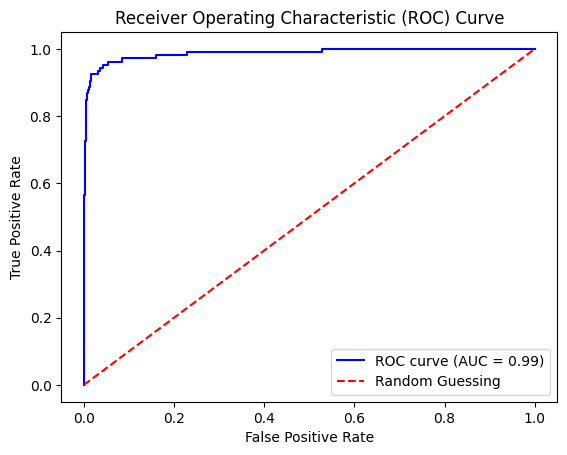

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the false positive rate (FPR), true positive rate (TPR), and threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.savefig('ResNet18_frozen_100epochs_roc_auc.png')
plt.show()